<a href="https://colab.research.google.com/github/InbalBolshinsky/DL_finalProject/blob/main/Lung_Cancer_Project_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lung Cancer Project DL


In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
import seaborn as sns

!pip install kagglehub
import kagglehub
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner # Keras Tuner for hyperparameter tuning
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


###Dataset Preparation

In [2]:
# Download dataset (default behavior)
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

print("Dataset downloaded to:", path)

100%|██████████| 199M/199M [00:03<00:00, 64.1MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset from default location to Google Drive
!cp -r /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset /content/drive/MyDrive/KaggleDatasets/LungCancer


Mounted at /content/drive
cp: cannot create directory '/content/drive/MyDrive/KaggleDatasets/LungCancer': No such file or directory


In [4]:
base_path = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2"
print("Base path:", base_path)

if os.path.exists(base_path):
    for root, dirs, files in os.walk(base_path):
        print(f"Directory: {root}")
        for d in dirs:
            print(f"  Subdirectory: {d}")
        #for f in files:
           # print(f"  File: {f}")
else:
    print(f"Path does not exist: {base_path}")

Base path: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
  Subdirectory: Test cases
  Subdirectory: The IQ-OTHNCCD lung cancer dataset
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/Test cases
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset
  Subdirectory: The IQ-OTHNCCD lung cancer dataset
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
  Subdirectory: Bengin cases
  Subdirectory: Malignant cases
  Subdirectory: Normal cases
Directory: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/B

In [5]:
input_shape = (128, 128, 3)
num_classes = 3  # Normal, Benign, Malignant

# Load and preprocess images
images = []
labels = []
categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [6]:
size_data = {}
for i in categories:
    # Fixed: Corrected the path to point to the image directory
    directory = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/"
    directory = os.path.join(directory, i) # Construct path to images in a category
    class_num = categories.index(i)
    temp_dict = {}
    # Fixed: Changed from path to directory, and added a loop
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file) # Construct filepath for each image
            # Check if file is an image to avoid errors
            if filepath.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    height, width, channels = imageio.imread(filepath).shape
                    if str(height) + ' x ' + str(width) in temp_dict:
                        temp_dict[str(height) + ' x ' + str(width)] += 1
                    else:
                        temp_dict[str(height) + ' x ' + str(width)] = 1
                except ValueError:
                    print(f"Skipping {filepath}: not a valid image file.")

    size_data[i] = temp_dict

size_data

<ipython-input-6-546d55099baf>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '512 x 623': 31,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

###Visualize Dataset

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases
Bengin cases


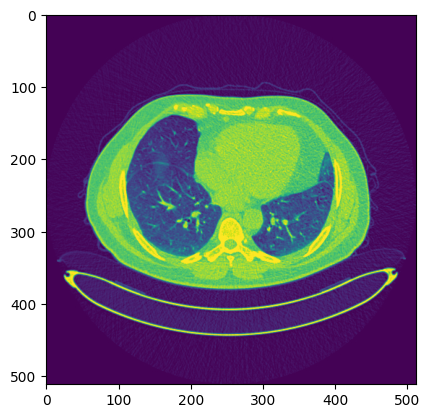

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases
Malignant cases


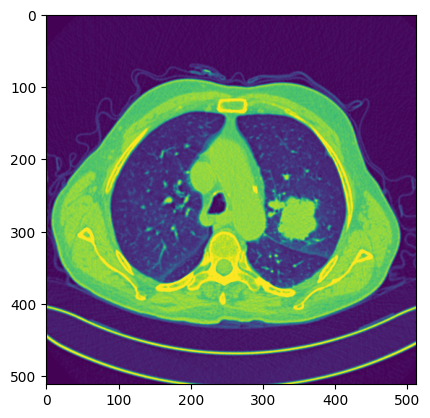

/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases
Normal cases


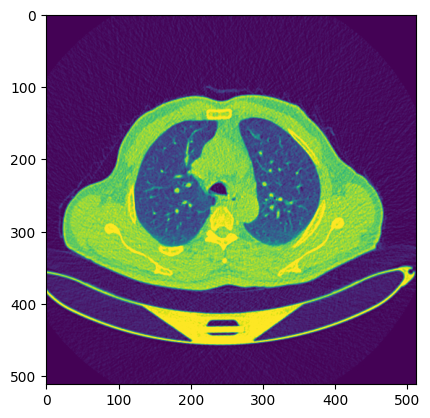

In [7]:
directory = "/root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset//versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/"
for i in categories:
    category_path = os.path.join(directory, i) # Construct path for each category
    print(category_path)
    class_num = categories.index(i)
    for file in os.listdir(category_path): # List files in the category path
        filepath = os.path.join(category_path, file) # Construct filepath using category path
        print(i)
        img = cv2.imread(filepath, 0)
        if img is not None: # Check if image was loaded successfully
            plt.imshow(img)
            plt.show()
            break
        else:
            print(f"Failed to load image: {filepath}")

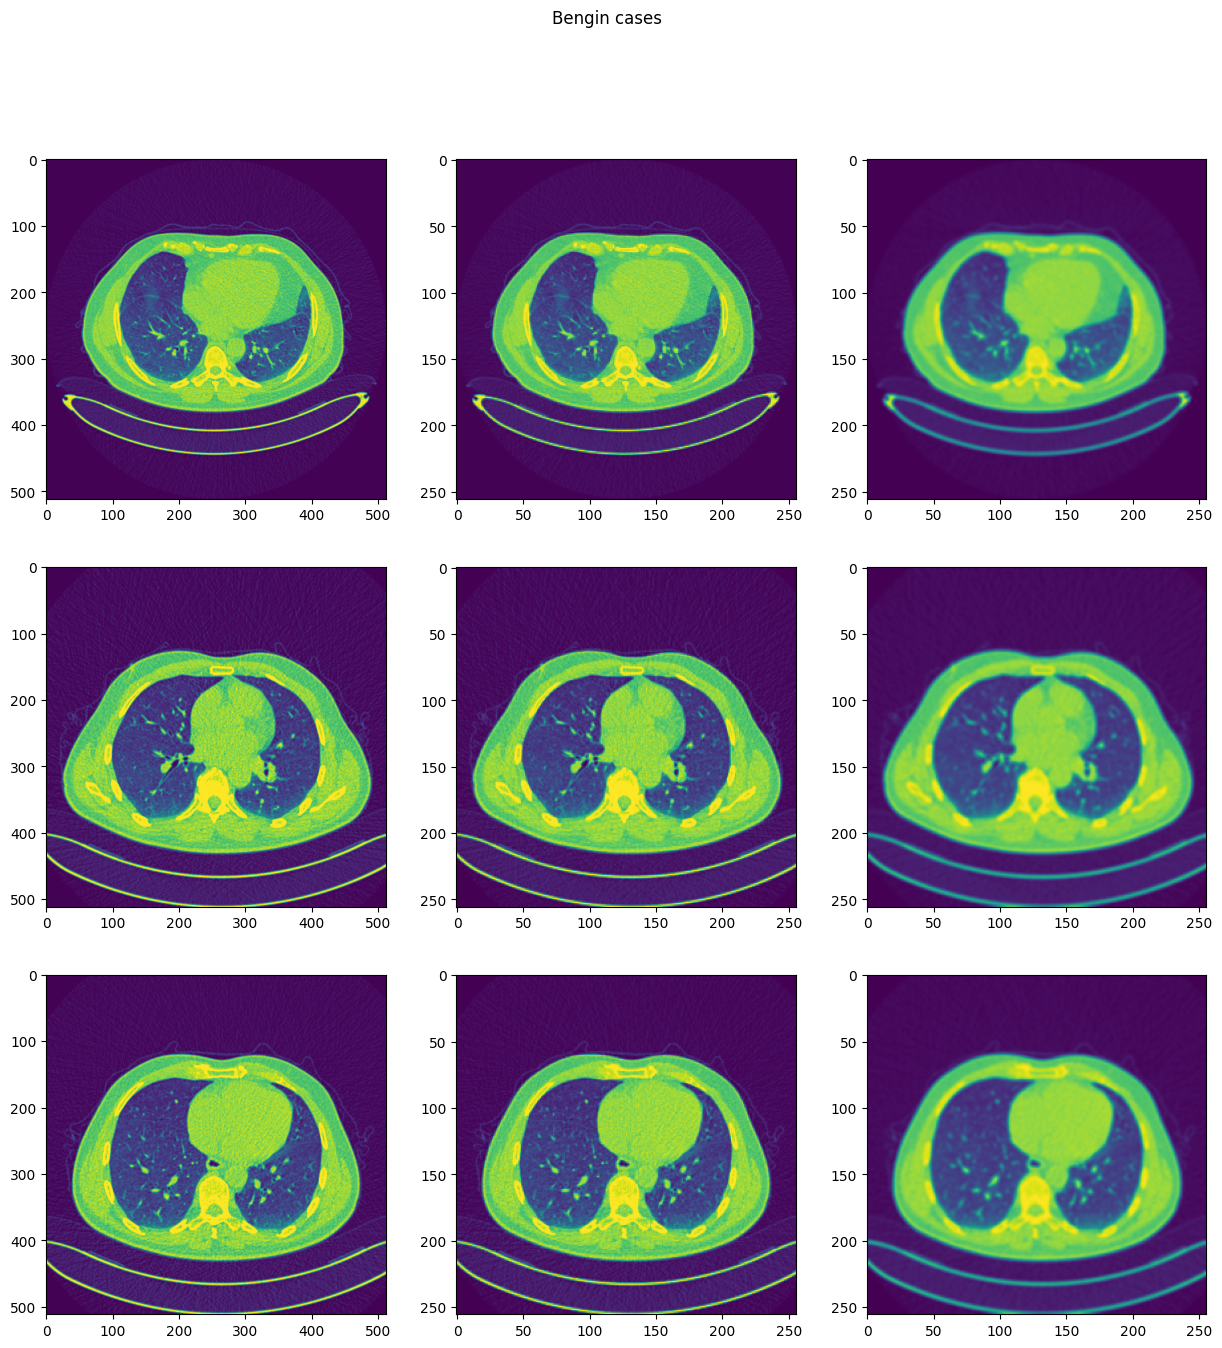

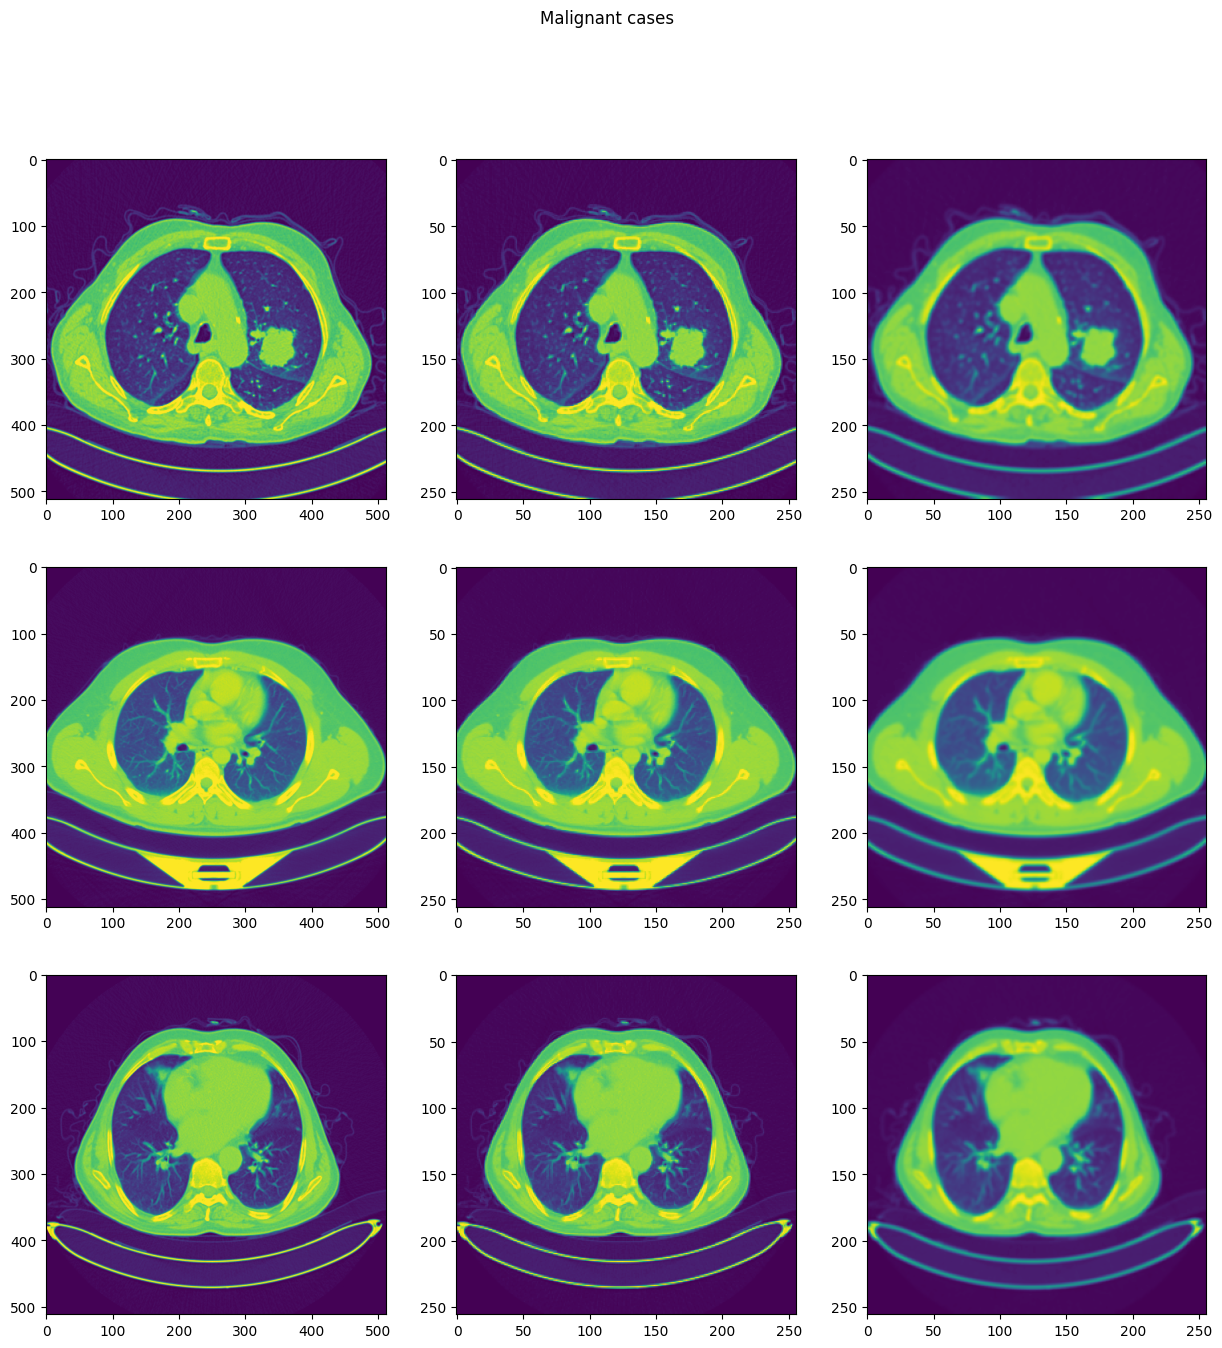

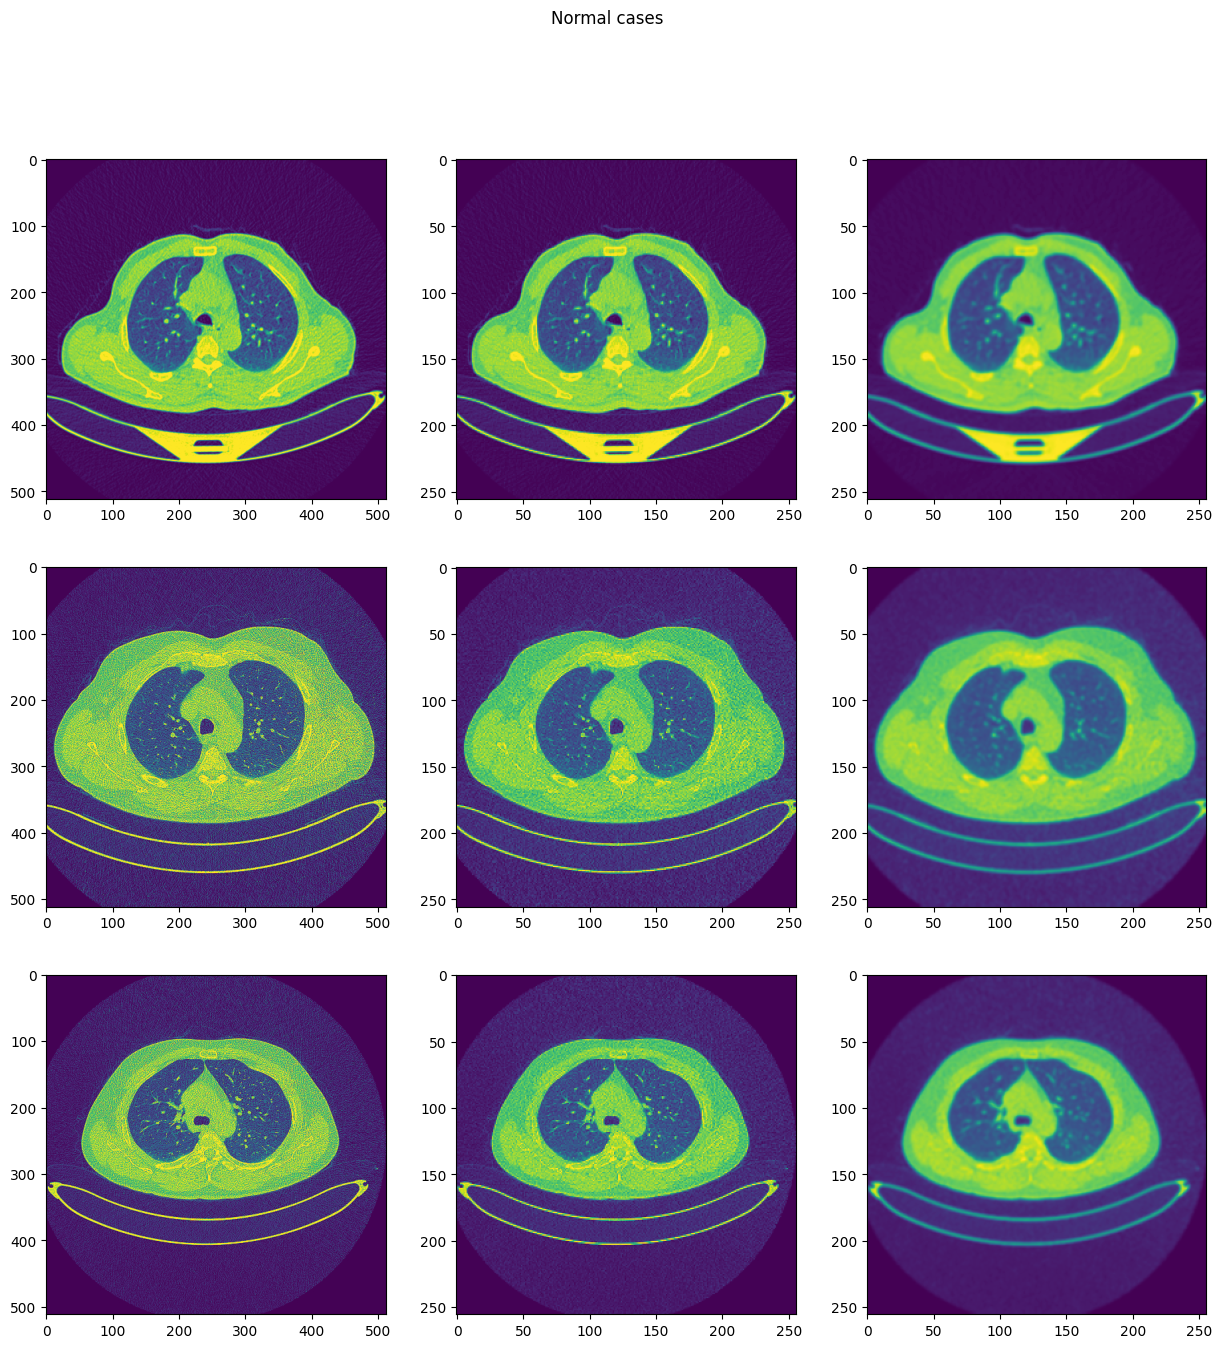

In [8]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

###Data Preprocessing

In [12]:
data = []
# Loop through each category and process images
for category in categories:
    path = os.path.join(directory, category)
    class_num = categories.index(category)

    if not os.path.exists(path):
        print(f"Error: Path does not exist -> {path}")
        continue

    for file in os.listdir(path):
        filepath = os.path.join(path, file)

        img = cv2.imread(filepath, 0)

        if img is None:
            print(f"Warning: Failed to load image {filepath}")
            continue

        img = cv2.resize(img, (img_size, img_size))

        data.append([img, class_num])

# Shuffle dataset to prevent order bias
random.shuffle(data)

# Split into feature (X) and label (y) arrays
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

# Print dataset details
print('X length:', len(X))
print('y counts:', Counter(y))

# Normalize images and reshape for CNN input
X = np.array(X).reshape(-1, img_size, img_size, 1)  # Reshape for CNN
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


###Applying SMOTE to oversample the data

In [ ]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [ ]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [ ]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


###Building CNN model

In [ ]:
model1 = Sequential()

# Convolutional layers
model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model1.add(Flatten())

# Fully connected layers
model1.add(Dense(512, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │     117,965,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,336,515 (451.42 MB)

 Trainable params: 118,336,515 (451.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.5962 - loss: 0.8486 - val_accuracy: 0.9491 - val_loss: 0.1734
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9763 - loss: 0.0938 - val_accuracy: 0.9891 - val_loss: 0.0427
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9937 - loss: 0.0323 - val_accuracy: 0.9600 - val_loss: 0.1181
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9925 - loss: 0.0353 - val_accuracy: 0.9782 - val_loss: 0.1064
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9944 - loss: 0.0267 - val_accuracy: 0.9891 - val_loss: 0.0287
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9927 - val_loss: 0.0339
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9976 - loss: 0.0126 - val_accuracy: 0.9927 - val_loss: 0.0403
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9947 - loss: 0.0214 - 

###Visualizing filters after training

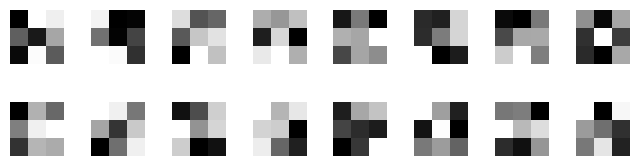

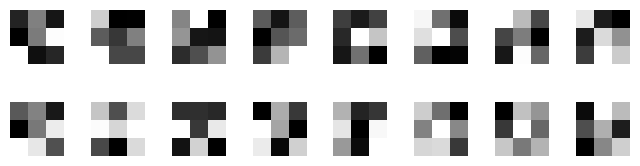

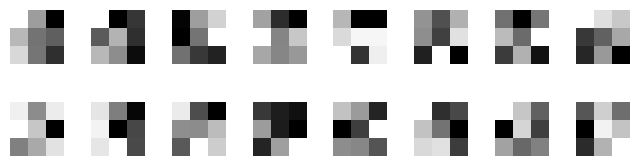

In [ ]:
def visualize_filters(layer, max_filters=16):
    filters = layer.get_weights()[0]
    filters = filters - filters.min()
    filters = filters / filters.max()
    filter_num = filters.shape[3]

    # Limit the number of filters to display
    filter_num = min(filter_num, max_filters)

    n_columns = 8  # Number of columns for displaying filters
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)  # Calculate the number of rows

    # Create a plot to display the filters
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))

    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        # Display only the first channel of the filter (input_channels = 0)
        axs[row, col].imshow(filters[:, :, 0, i], cmap='gray')  # Show the first channel of the filter
        axs[row, col].axis('off')

    # Adjust the layout to avoid excessive spacing between filters
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Display filters for all Conv2D layers after training
for layer in model1.layers:
    if isinstance(layer, Conv2D):  # Show filters only for Conv2D layers
        visualize_filters(layer)


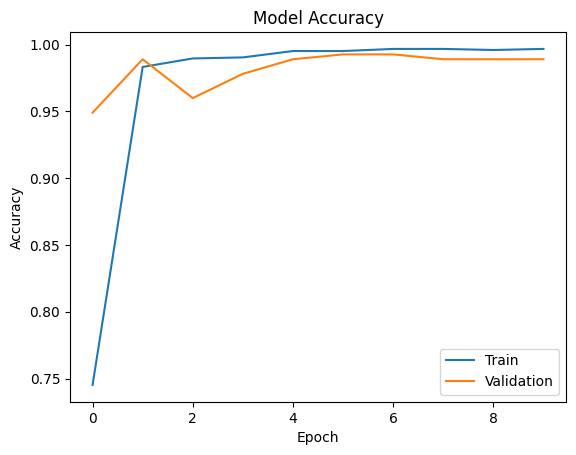

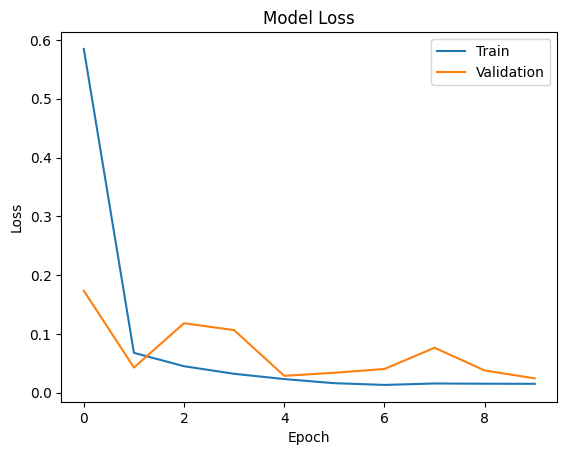

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 473ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        30
           1       1.00      1.00      1.00       141
           2       1.00      0.97      0.99       104

    accuracy                           0.99       275
   macro avg       0.97      0.99      0.98       275
weighted avg       0.99      0.99      0.99       275



Confusion Matrix:
 [[ 30   0   0]
 [  0 141   0]
 [  3   0 101]]


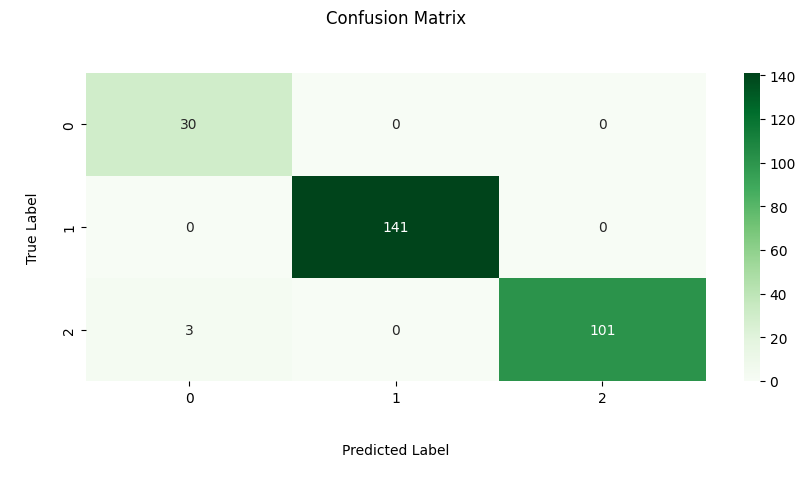

In [ ]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_bool)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

###Building the same model, only this time with earlystopping

In [ ]:
#this should be more efficient.
# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
    patience=3,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Define the optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model1.compile(
    optimizer=optimizer,
   loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model1.fit(
    X_train_sampled,
    y_train_sampled,
    batch_size=8,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop]  # Add the EarlyStopping callback here
)

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.9564 - val_loss: 0.1201
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9984 - loss: 0.0112 - val_accuracy: 0.9855 - val_loss: 0.0225
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9938 - loss: 0.0159 - val_accuracy: 0.9818 - val_loss: 0.0281
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.9782 - val_loss: 0.0521
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9949 - loss: 0.0201 - val_accuracy: 0.9964 - val_loss: 0.0154
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9923 - loss: 0.0199 - val_accuracy: 0.9855 - val_loss: 0.0344
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9927 - val_loss: 0.0103
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 1.0000 - loss: 3.4226e-0

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       141
           2       1.00      1.00      1.00       104

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



Confusion Matrix:
 [[ 30   0   0]
 [  0 141   0]
 [  0   0 104]]


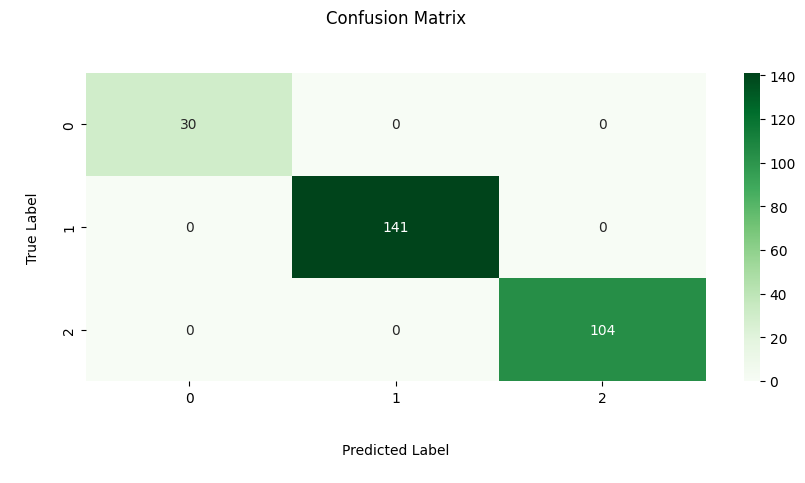

In [ ]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_bool)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

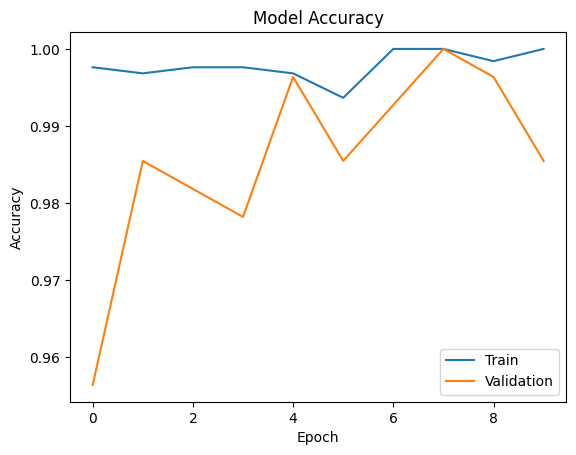

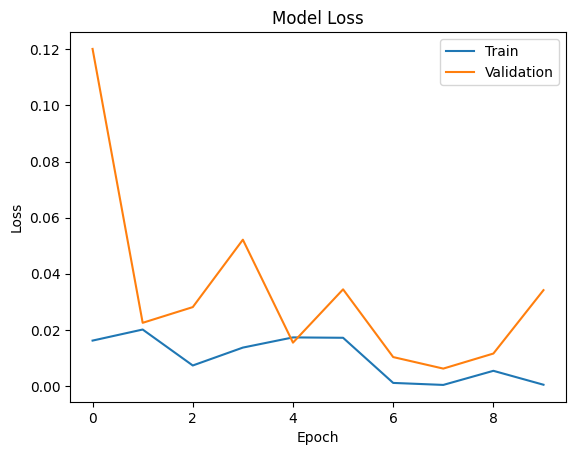

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

###Hyperparameters Tuning and Testing the Model

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Conv2D(
        filters=hp.Choice('conv_1_filters', values=[16, 32]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(256, 256, 1)  # Define input shape
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces spatial dimensions by half

    # Second convolutional layer
    model.add(Conv2D(
        filters=hp.Choice('conv_2_filters', values=[32, 64]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces dimensions further

    # Third convolutional layer
    model.add(Conv2D(
        filters=hp.Choice('conv_3_filters', values=[64, 128]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Final pooling to reduce dimensions

    # Flatten and fully connected layers
    model.add(Flatten())  # Now the flattened size will be smaller
    model.add(Dense(
        units=hp.Choice('dense_units', values=[64, 128]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model1.summary()

    return model

In [ ]:
# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=3,          # Stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True  # Revert to the best weights
)

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,  # Reduce max epochs
    factor=2,      # Reduce the number of trials per round
    directory='hyperparameter_tuning',
    project_name='lung_cancer_model'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     117,965,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,009,547 (1.32 GB)

 Trainable params: 118,336,515 (451.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,673,032 (902.84 MB)

In [ ]:
tuner.search(
    X_train, y_train,  # Training data
    epochs=5,                         # Number of epochs for each trial
    validation_data=(X_valid, y_valid), # Validation data
    callbacks=[early_stop],           # Early stopping callback
    batch_size=4
)

Trial 21 Complete [00h 00m 22s]
val_accuracy: 0.9818181991577148

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 05m 38s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]  # Get the best hyperparameter set
print("Best Hyperparameters:", best_hps.values)

Best Hyperparameters: {'conv_1_filters': 16, 'conv_2_filters': 32, 'conv_3_filters': 64, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


In [ ]:
# Build the best model
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(
    X_train, y_train,
    epochs=20,  # You can extend training here
    batch_size=16,  # You can set this to the best batch size if tuned
    validation_data=(X_valid, y_valid)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     117,965,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,009,547 (1.32 GB)

 Trainable params: 118,336,515 (451.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,673,032 (902.84 MB)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.5791 - loss: 1.0029 - val_accuracy: 0.8045 - val_loss: 0.4948
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8172 - loss: 0.4302 - val_accuracy: 0.9182 - val_loss: 0.2244
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9233 - loss: 0.2284 - val_accuracy: 0.9864 - val_loss: 0.0544
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9463 - loss: 0.1282 - val_accuracy: 0.9955 - val_loss: 0.0248
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9746 - loss: 0.0785 - val_accuracy: 0.9773 - val_loss: 0.0475
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9615 - loss: 0.1031 - val_accuracy: 0.9955 - val_loss: 0.0200
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9787 - loss: 0.0475 - val_accuracy: 0.9955 - val_loss: 0.0126
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9870 - loss: 0.0373 - val_accuracy: 1.0000 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_valid, y_valid)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.9776 - loss: 0.0444
Test Loss: 0.029477786272764206
Test Accuracy: 0.9863636493682861


In [ ]:
model.save('lung_cancer_tuned_model.h5')

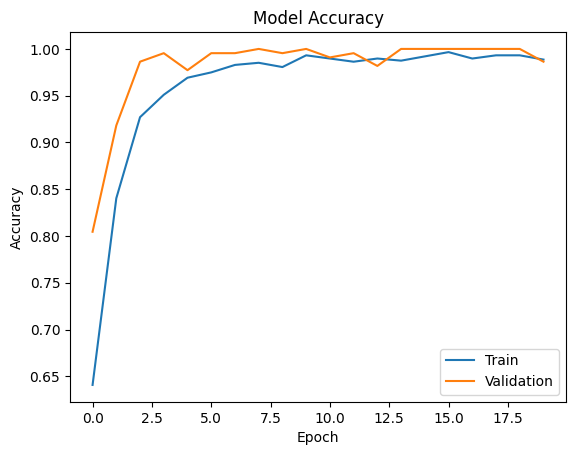

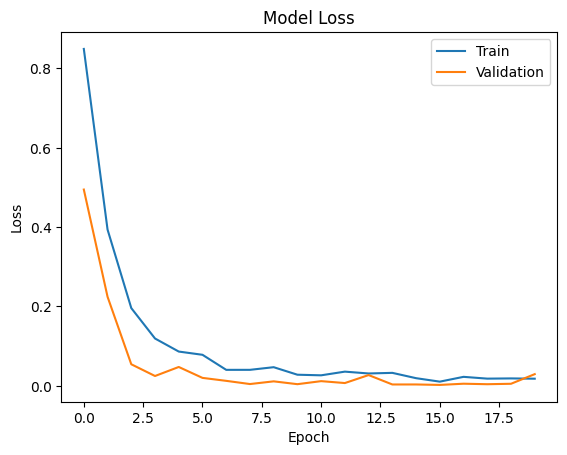

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#comparing a CNN model with a transfer learning embedding

In [ ]:
# Expand grayscale images to 3 channels
X_train_sampled_3ch = np.repeat(X_train_sampled, 3, axis=-1)  # (num_samples, 256, 256, 3)
X_valid_3ch = np.repeat(X_valid, 3, axis=-1)  # (num_samples, 256, 256, 3)

# Keep the labels as 1D arrays (do not expand them)
y_train_sampled_3ch = y_train_sampled  # No change
y_valid_3ch = y_valid  # No change

# Check the new shape
print("New X_train shape:", X_train_sampled_3ch.shape)  # Should be (num_samples, 256, 256, 3)
print("New X_valid shape:", X_valid_3ch.shape)  # Should be (num_samples, 256, 256, 3)
print("y_train shape:", y_train_sampled.shape)  # Should be (num_samples,)
print("y_valid shape:", y_valid.shape)  # Should be (num_samples,)

New X_train shape: (1260, 256, 256, 3)
New X_valid shape: (220, 256, 256, 3)
y_train shape: (1260,)
y_valid shape: (220,)


In [ ]:
# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Final model
transfer_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history_transfer = transfer_model.fit(
    X_train_sampled_3ch,  # Use the updated 3-channel training data
    y_train_sampled,
    batch_size=8,
    epochs=10,
    validation_data=(X_valid_3ch, y_valid),  # Use the updated 3-channel validation data
    #callbacks=[early_stop]
)

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.5057 - loss: 2.2302 - val_accuracy: 0.8636 - val_loss: 0.4108
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.6814 - loss: 0.6629 - val_accuracy: 0.9318 - val_loss: 0.2950
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.7240 - loss: 0.5888 - val_accuracy: 0.9000 - val_loss: 0.2587
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.7849 - loss: 0.5354 - val_accuracy: 0.9273 - val_loss: 0.2119
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7175 - loss: 0.5707 - val_accuracy: 0.9682 - val_loss: 0.1484
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8239 - loss: 0.4271 - val_accuracy: 0.9818 - val_loss: 0.1468
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.8303 - loss: 0.4117 - val_accuracy: 0.9591 - val_loss: 0.1117
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8547 - loss: 0.3781 -

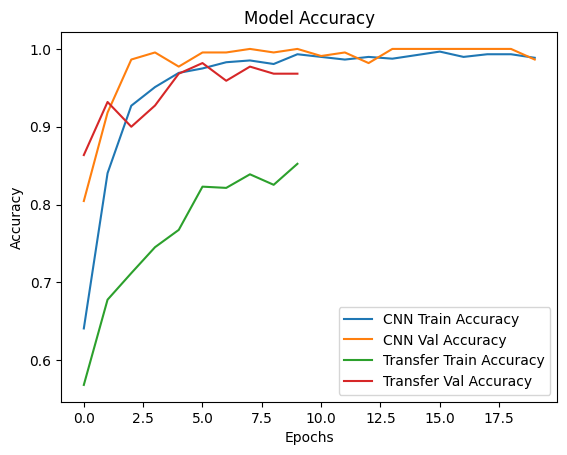

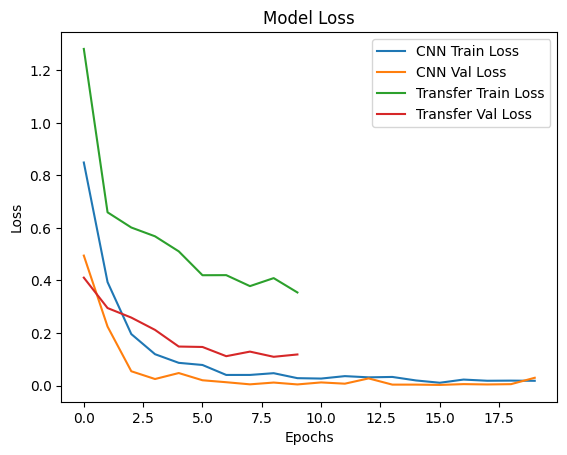

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN Val Accuracy')
plt.plot(history_transfer.history['accuracy'], label='Transfer Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Transfer Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='CNN Train Loss')
plt.plot(history.history['val_loss'], label='CNN Val Loss')
plt.plot(history_transfer.history['loss'], label='Transfer Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Transfer Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Fine tuning the transformer model


In [ ]:
class_labels = ['Bengin cases', 'Malignant cases', 'Normal cases']  # Define class labels
# Step 1: Unfreeze layers in the base model
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but the last 10 layers
    layer.trainable = False

# Step 2: Re-compile the model with a lower learning rate
transfer_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 3: Fine-tune the model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_fine_tune = transfer_model.fit(
    X_train_sampled_3ch,
    y_train_sampled,
    validation_data=(X_valid_3ch, y_valid),
    epochs=10,
    batch_size=8,
    callbacks=[early_stop]
)

# Step 4: Evaluate the fine-tuned model
transfer_predictions_fine_tune = transfer_model.predict(X_valid_3ch)
transfer_predictions_fine_tune = np.argmax(transfer_predictions_fine_tune, axis=1)

print("Classification Report for Fine-Tuned Transfer Learning Model:")
print(classification_report(y_valid, transfer_predictions_fine_tune, target_names=class_labels))

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.8511 - loss: 0.3716 - val_accuracy: 0.9909 - val_loss: 0.0496
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.8915 - loss: 0.2665 - val_accuracy: 1.0000 - val_loss: 0.0196
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.8829 - loss: 0.2960 - val_accuracy: 0.9909 - val_loss: 0.0301
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.8922 - loss: 0.2497 - val_accuracy: 0.9955 - val_loss: 0.0171
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9221 - loss: 0.1838 - val_accuracy: 1.0000 - val_loss: 0.0171
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9124 - loss: 0.2195 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9427 - loss: 0.1321 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9383 - loss: 0

In [ ]:
# Predictions for CNN Model
cnn_predictions = model.predict(X_valid)
cnn_predictions = np.argmax(cnn_predictions, axis=1)  # Convert probabilities to class labels

# Predictions for Transfer Learning Model
transfer_predictions = transfer_model.predict(X_valid_3ch)
transfer_predictions = np.argmax(transfer_predictions, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


In [ ]:
# Classification report for CNN
print("Classification Report for CNN Model:")
print(classification_report(y_valid, cnn_predictions, target_names=class_labels))

# Classification report for Transfer Learning
print("Classification Report for Transfer Learning Model:")
print(classification_report(y_valid, transfer_predictions, target_names=class_labels))

Classification Report for CNN Model:
                 precision    recall  f1-score   support

   Bengin cases       1.00      0.87      0.93        23
Malignant cases       1.00      1.00      1.00       123
   Normal cases       0.96      1.00      0.98        74

       accuracy                           0.99       220
      macro avg       0.99      0.96      0.97       220
   weighted avg       0.99      0.99      0.99       220

Classification Report for Transfer Learning Model:
                 precision    recall  f1-score   support

   Bengin cases       1.00      1.00      1.00        23
Malignant cases       1.00      1.00      1.00       123
   Normal cases       1.00      1.00      1.00        74

       accuracy                           1.00       220
      macro avg       1.00      1.00      1.00       220
   weighted avg       1.00      1.00      1.00       220



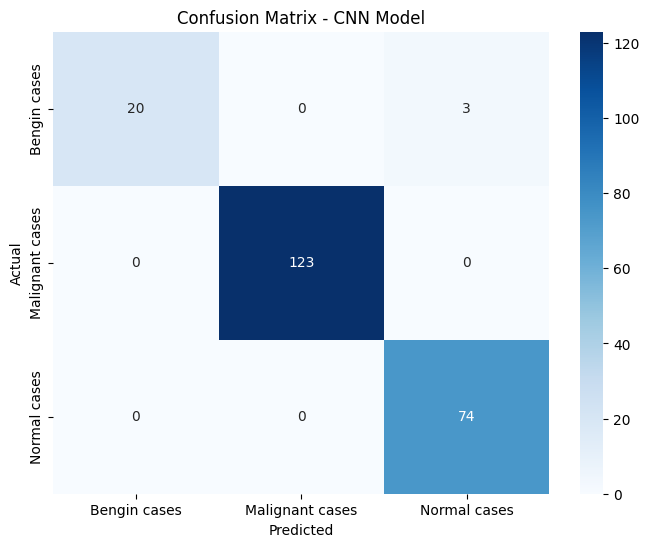

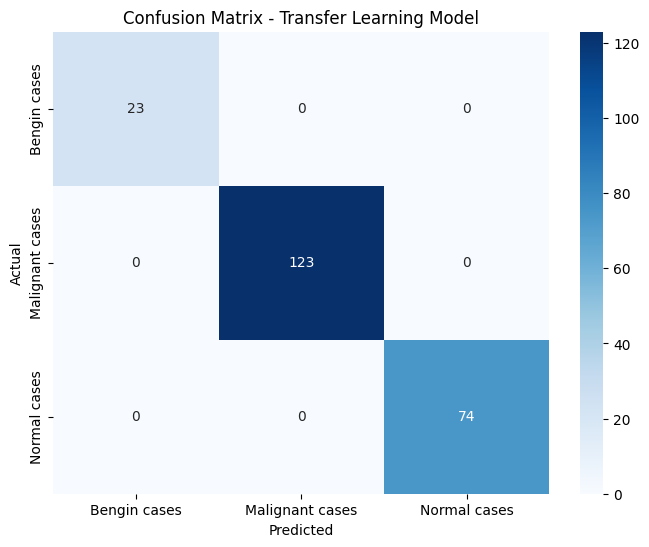

In [ ]:
# Confusion matrix for CNN
cnn_cm = confusion_matrix(y_valid, cnn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for Transfer Learning
transfer_cm = confusion_matrix(y_valid, transfer_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(transfer_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Transfer Learning Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

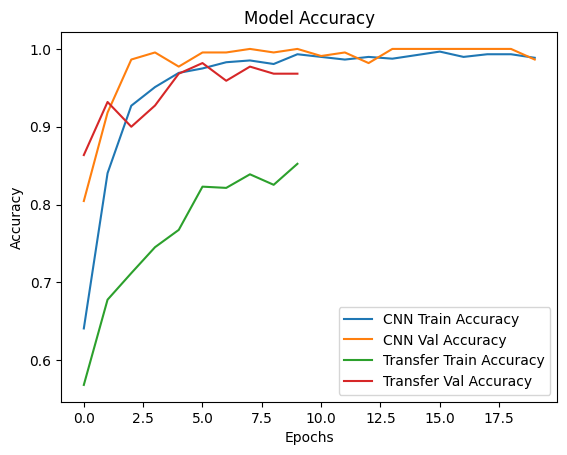

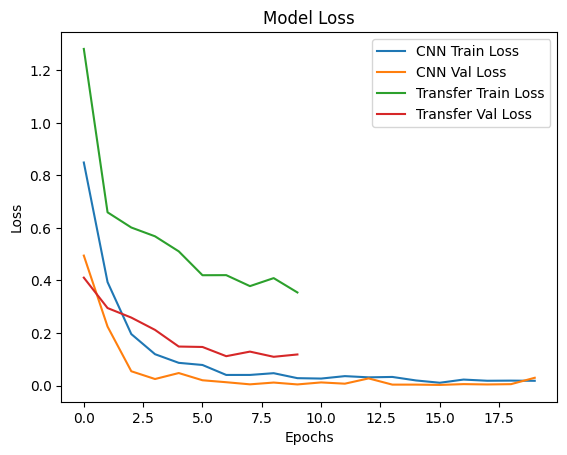

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN Val Accuracy')
plt.plot(history_transfer.history['accuracy'], label='Transfer Train Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Transfer Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='CNN Train Loss')
plt.plot(history.history['val_loss'], label='CNN Val Loss')
plt.plot(history_transfer.history['loss'], label='Transfer Train Loss')
plt.plot(history_transfer.history['val_loss'], label='Transfer Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()